**Transfer Learning**


Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a language model (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-example-overview.png)

[Paper Link](https://arxiv.org/pdf/2106.10270)

Where you can find Pre-Trained Models

1. `torchvision.models, torchtext.models, torchaudio.models, torchrec.models`
2.  https://huggingface.co/models

We're going through following steps :-


1. Getting and Preparing data
2. Loading Pre-trained Model
3. Training Model
4. Evaluation & Inference

#### **Getting and Preparing data**

In [1]:
!pip install -q torchinfo

In [2]:
!git clone https://github.com/d0r1h/Learn-AI.git
!mv /content/Learn-AI/PyTorch/Pytorch\ by\ Daniel\ Bourke/going_modular .
!rm -rf /content/Learn-AI

Cloning into 'Learn-AI'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 496 (delta 7), reused 42 (delta 4), pack-reused 447 (from 2)
Receiving objects: 100% (496/496), 104.92 MiB | 26.47 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [3]:
import torch
import torchvision
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms
import matplotlib.pyplot as plt

from going_modular import data_setup, engine

In [4]:
# Downloading the data

import os
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

**Datasets and DataLoaders**

When using a pretrained model, it's important that custom data going into the model is prepared in the same way as the original training data that went into the model.

In [6]:
'''
1. Reshape all images to 224x224 (though some models may require different sizes)
2. Turn image values to between 0 & 1
3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
'''

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b6f094906e0>,
 ['pizza', 'steak', 'sushi'])

Above we have create a manual transform which changes the input according to the models, but Ideal way to do that is use Pre-trained models weights and then do auto transform.

Let's see how we can do that.

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # Get a set of pretrained model weights
auto_transforms = weights.transforms() # Get the transforms used to create our pretrained weights

print(weights)
print(auto_transforms)

EfficientNet_B0_Weights.IMAGENET1K_V1
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

In [9]:
# Create training and testing DataLoaders as well as get a list of class names


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b6f094d15e0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#### **Getting a pretrained model**


We'll be using `efficientnet_b0`, introduced in [EfficientNet](https://arxiv.org/pdf/1905.11946)

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png)

In [11]:
device  = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
# Loading Pre-trained Model

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s]


`efficientnet_b0` comes in three main parts:

1. **features** - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").
2. **avgpool** - Takes the average of the output of the features layer(s) and turns it into a feature vector.
3. **classifier** - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png)

In [13]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

**Freezing the base model and changing the output layer to suit our needs**

The process of transfer learning usually goes: *freeze* some base layers of a pretrained model (typically the features section) and then adjust the *output layers* (also called head/classifier layers) to suit your needs.


![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png)


In [14]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False

for param in model.features.parameters():
    param.requires_grad = False

In [15]:
'''
Let's now adjust the output layer or the classifier portion of our pretrained model to our needs.
Right now our pretrained model has out_features=1000 because there are 1000 classes in ImageNet.
We can change the classifier portion of our model by creating a new series of layers.

We'll keep the Dropout layer the same using torch.nn.Dropout(p=0.2, inplace=True)
And we'll keep in_features=1280 for our Linear output layer but we'll change the out_features value to the length of our class_names (len(['pizza', 'steak', 'sushi']) = 3)

'''

print(model.classifier) # current classifier of the pre-trained model

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(class_names)


model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

Now let's see if the Feature extraction layers are Frozen (Trainable = False) except the final classifier.

Evan trainable parameter would have reduced a lot lot lot ....

In [17]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

#### **Training Model**

In [23]:
from timeit import default_timer as timer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)


start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()


print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5413 | train_acc: 0.9141 | test_loss: 0.5434 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4583 | train_acc: 0.9336 | test_loss: 0.5219 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4375 | train_acc: 0.9062 | test_loss: 0.5266 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.4668 | train_acc: 0.8281 | test_loss: 0.4599 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4135 | train_acc: 0.8320 | test_loss: 0.4728 | test_acc: 0.8456
Epoch: 6 | train_loss: 0.4186 | train_acc: 0.8281 | test_loss: 0.4505 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.3860 | train_acc: 0.9453 | test_loss: 0.4367 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.3998 | train_acc: 0.8438 | test_loss: 0.4333 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.4890 | train_acc: 0.8281 | test_loss: 0.4325 | test_acc: 0.8561
Epoch: 10 | train_loss: 0.3901 | train_acc: 0.8320 | test_loss: 0.3728 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.3238 | train_acc: 0.9570 | test_loss: 0.3986 | test_acc: 0.8456
Epoch: 12 | train_l

Wow, with 20 Epoch, we got ~85% of test accuracy and in the last model (Custom Dataset) we had just 33% even after training for 20 Epoch.

Power of Transfer learning,

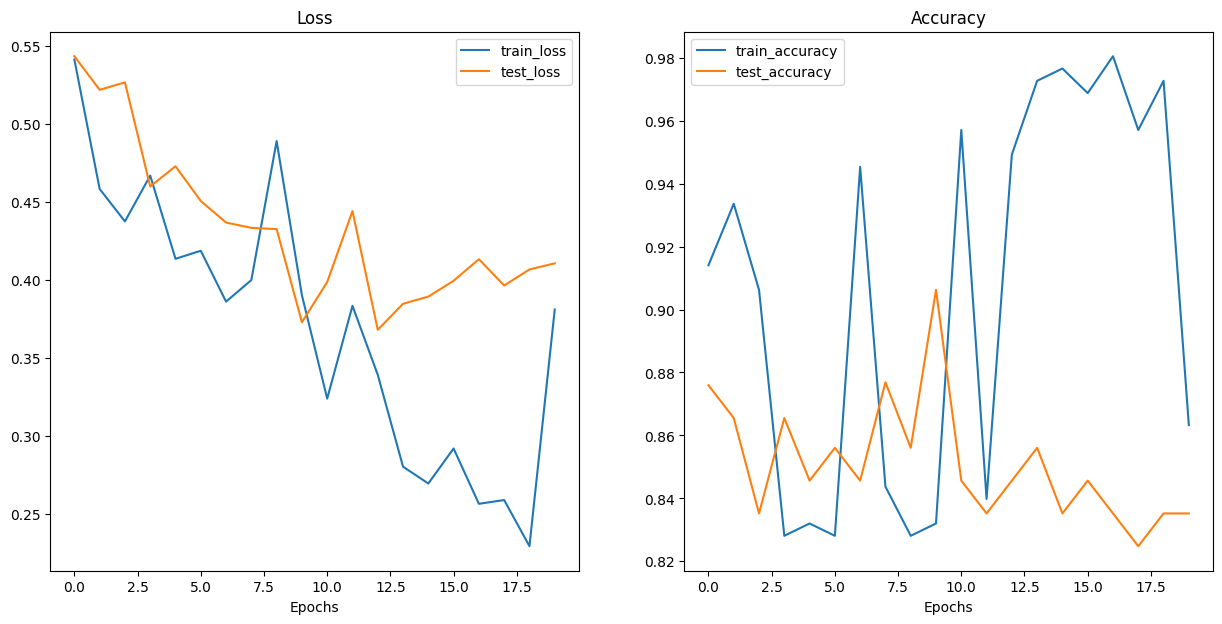

In [24]:
# Let's get the helperfunction and plot the metrics

with open("helper_functions.py", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  f.write(request.content)

from helper_functions import plot_loss_curves

plot_loss_curves(results)

**Now Let's make predicton on custom image**

In [25]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)
    model.eval()

    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

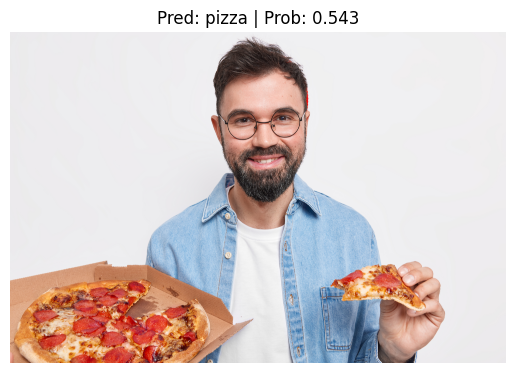

In [26]:
custom_image_path = "/content/pleased-handsome-bearded-man-eats-delicious-pizza-dinner-feels-hungry-wears-round-glasses-shirt-eats-junk-food.jpg"

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

Eariler we have just 37% probabilty, now it's increase to 54% great.

This can be furher enchance by

1. Adding more data
2. Peroforming additional augmentation
3. Training for more epoches

----

https://www.v7labs.com/blog/transfer-learning-guide